## Load packages and data

In [242]:
import pickle
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from modeling_utils import get_classifier_scores, get_classifier_performance, get_feature_names

In [243]:
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [244]:
df = pickle.load(open("processed_data.pickle", "rb"))

## Model 1: "Conduct Occurred" ruling
This model will apply to the entire dataset, and try to predict whether the CCRB determines that a complaint did occur (i.e. was ruled "substantiated" or "exonerated").

### Define features + target,  preprocessing steps and to train/test split

In [245]:
# define features and target
# consider adding precinct as categorical variable
features_list = ['mos_age_incident', 'complainant_age_incident', 'complaint_age', 'complaint_is_grouped',
                 'officer_cumcount', 'command_rank_num', 'percent_unemployed_mean', 'percent_nohs_mean', 'mos_ethnicity',
                 'mos_gender', 'complainant_ethnicity', 'complainant_gender', 'fado_type', 'contact_reason', 'outcome_description']

X1 = df[features_list]
y1 = df['ruling_conduct_occurred']

In [246]:
# define numeric and categorical features
numeric_features = ['mos_age_incident', 'complainant_age_incident', 'complaint_age', 'officer_cumcount',
                    'command_rank_num', 'percent_unemployed_mean', 'percent_nohs_mean']
categorical_features = ['mos_ethnicity', 'mos_gender', 'complainant_ethnicity', 'complainant_gender',
                        'fado_type', 'contact_reason', 'outcome_description']

In [247]:
# create preprocessor pipeline steps to process numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [248]:
# split data into training and test set
X1, X1_test, y1, y1_test = train_test_split(
    X1, y1, test_size=.2, random_state=33) 

### Try a bunch of classifiers with cross-validation

In [249]:
clf_models_list = [
    LogisticRegression(max_iter=500),
    RandomForestClassifier(random_state=33),
    KNeighborsClassifier(3),
    SVC(random_state=33),
    GradientBoostingClassifier(random_state=33),
    GaussianNB()
    ]

In [250]:
# test the same set of classifiers using same preprocessing techniques
get_classifier_scores(X1,y1,clf_models_list,preprocessor)

LogisticRegression(max_iter=500)
0.6194487813409999
RandomForestClassifier(random_state=33)
0.6729936863685682
KNeighborsClassifier(n_neighbors=3)
0.621082744673315
SVC(random_state=33)
0.632559171720154
GradientBoostingClassifier(random_state=33)
0.6369735786290469
GaussianNB()
0.601306467148313


Looks like Random Forest fits my data best of the models tried. Now I'll examine some additional metrics and then see if I can optimize the model.

### Baseline Random Forest Performance Metrics

              precision    recall  f1-score   support

           0       0.67      0.62      0.64     10844
           1       0.67      0.72      0.69     11810

    accuracy                           0.67     22654
   macro avg       0.67      0.67      0.67     22654
weighted avg       0.67      0.67      0.67     22654



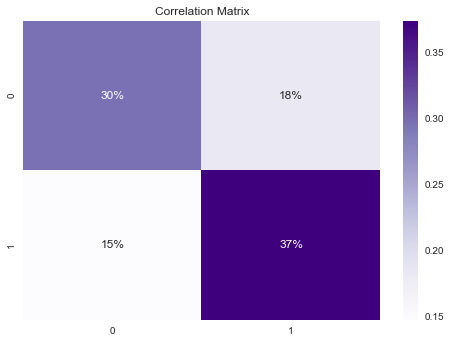

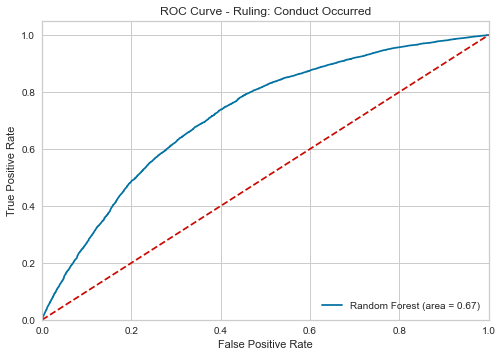

In [251]:
# evaluate Random Forest performance with default hyperparameters
get_classifier_performance(X=X1,y=y1,model=RandomForestClassifier(),preprocessor=preprocessor)

### Hyperparameter Tuning

In [252]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint

In [253]:
# Number of trees in random forest
n_estimators = [100,200,300,400,500]
# Number of features to consider at every split
max_features = ['auto','log2']
# Maximum number of levels in tree
max_depth = [4,5,6,7,8]

# Create the random grid
param_grid = {'classifier__n_estimators': n_estimators,
               'classifier__max_features': max_features,
               'classifier__max_depth': max_depth}
pprint(param_grid) 

{'classifier__max_depth': [4, 5, 6, 7, 8],
 'classifier__max_features': ['auto', 'log2'],
 'classifier__n_estimators': [100, 200, 300, 400, 500]}


In [254]:
# create the baseline model to tune
rf1 = Pipeline(steps=[('preprocessor', preprocessor),('classifier', RandomForestClassifier())])

# run random search cross validation
rf1_grid = GridSearchCV(estimator = rf1, param_grid = param_grid, verbose=1)


In [255]:
# fit the grid search model
rf1_grid.fit(X1, y1) 

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  9.7min finished


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['mos_age_incident',
                                                                          'complainant_age_incident',
                                                                          'complaint_age',
                                                                          'officer_cumcount',
                                              

In [256]:
# get the best parameters from the grid search
rf1_grid.best_params_

{'classifier__max_depth': 8,
 'classifier__max_features': 'auto',
 'classifier__n_estimators': 300}

              precision    recall  f1-score   support

           0       0.70      0.40      0.51     10844
           1       0.60      0.85      0.71     11810

    accuracy                           0.63     22654
   macro avg       0.65      0.62      0.61     22654
weighted avg       0.65      0.63      0.61     22654



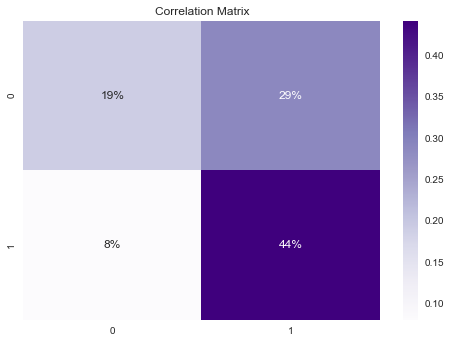

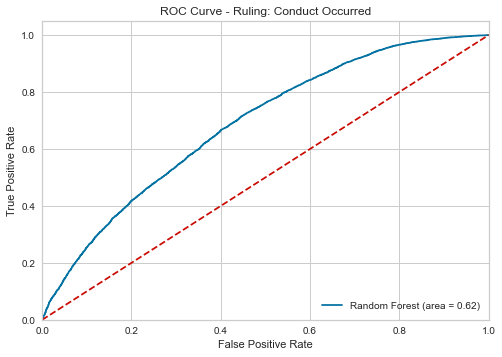

In [257]:
get_classifier_performance(X=X1,y=y1,model=RandomForestClassifier(n_estimators=300, max_depth=8,max_features='auto'),
                           preprocessor=preprocessor)

## Model 2: "Violated Rules" ruling
This model will apply only to complaints that the CCRB determined _did_ occur, and try to predict whether the complaint is ruled "substantiated" (the officer's conduct violated rules) or "exonerated" (the officer's conduct did not violate NYPD rules).\

### Define features + target,  preprocessing steps and to train/test split
Will use the same set of preprocessing steps as Model 1, since features are the same.

In [15]:
# filter out any "unsubstantiated" complaints and save as new dataframe
indexNames = df[df['disposition_clean'] == 'Unsubstantiated'].index
df2 = df.drop(indexNames)

# define X and y for 'violated rules' model
X2 = df2[features_list]
y2 = df2['ruling_conduct_violated_rules']

In [16]:
# split into training and test set
X2, X2_test, y2, y2_test = train_test_split(
    X2, y2, test_size=.2, random_state=33) 

### Try a bunch of classifiers with cross validation

In [21]:
# test the same set of classifiers using same preprocessing techniques
get_classifier_scores(X2,y2,clf_models_list,preprocessor)

LogisticRegression(max_iter=500)
0.6907998642918216
RandomForestClassifier(random_state=33)
0.7530133122231721
KNeighborsClassifier(n_neighbors=3)
0.687574381983947
SVC(random_state=33)
0.7087091299765969
GradientBoostingClassifier(random_state=33)
0.716262507446302
GaussianNB()
0.594296078653118


Looks like Random Forest is fitting my data best. Now I'll check to see whether it can be optimized.

### Baseline Random Forest Performance Metrics

              precision    recall  f1-score   support

           0       0.77      0.76      0.77      6222
           1       0.74      0.74      0.74      5560

    accuracy                           0.75     11782
   macro avg       0.75      0.75      0.75     11782
weighted avg       0.75      0.75      0.75     11782



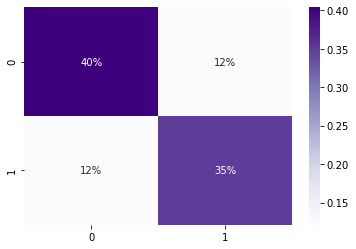

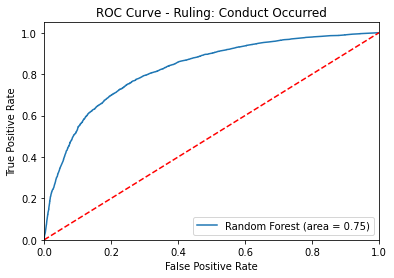

In [104]:
get_classifier_performance(X=X2,y=y2,model=RandomForestClassifier(),preprocessor=preprocessor)

In [152]:
rf2 = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', RandomForestClassifier())])

In [236]:
# try actuall getting X and Y
X2_processed = Pipeline(steps=[('preprocessor', preprocessor)]).fit(X2)

In [237]:
X2_processed

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['mos_age_incident',
                                                   'complainant_age_incident',
                                                   'complaint_age',
                                                   'officer_cumcount',
                                                   'command_rank_num',
                                                   'percent_unemployed_mean',
                                                   'percent_nohs_mean']),
                                                 ('ca

In [222]:
# fit final model
rf2.fit(X2,y2)

# extract feature names and importance from model
feature2_importance =pd.DataFrame(rf2.named_steps['classifier'].feature_importances_.flatten(), 
                                  index=get_feature_names(preprocessor))

# print feature names and importance in df
feature2_importance.sort_values(0,ascending=False)

,0
num__complaint_age,0.147267
num__complainant_age_incident,0.101155
num__mos_age_incident,0.086649
num__percent_nohs_mean,0.086571
num__percent_unemployed_mean,0.085877
onehot__x4_Force,0.064865
num__officer_cumcount,0.063832
onehot__x6_Arrest,0.031032
onehot__x4_Discourtesy,0.027408
onehot__x4_Abuse of Authority,0.026999


Note: credit to [Johannes Haupt](https://johaupt.github.io/scikit-learn/tutorial/python/data%20processing/ml%20pipeline/model%20interpretation/columnTransformer_feature_names.html) for the get_feature_names function.

In [221]:
from sklearn.inspection import plot_partial_dependence

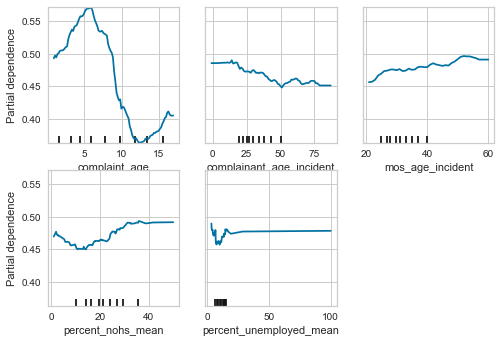

In [241]:
pdp_features = ['complaint_age','complainant_age_incident','mos_age_incident',
               'percent_nohs_mean','percent_unemployed_mean']

plot_partial_dependence(rf2, X2, pdp_features);

In [220]:
# print heatmap to understand the direction of random forest feature importances
#sns.heatmap(df2[features_list])
